<a href="https://colab.research.google.com/github/Maruddo/AI-Notebooks/blob/main/Transformer_Sentiment_Analysis/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipykernel_8644/4035465286.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights), strict=False)


Test Error: 
 Accuracy: 94.6%, Avg loss: 0.154550 



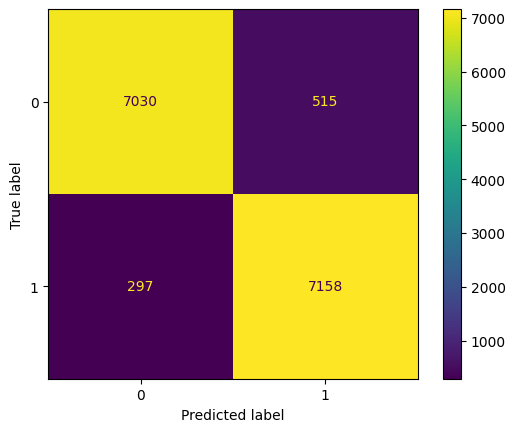

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torch import nn
from transformers import BertTokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

class IMBDDataset(Dataset):
    def __init__(self, file_path, tokenizer):
        df = pd.read_csv(file_path)
        df["sentiment"] = np.where(df["sentiment"] == "positive", 1, 0)
        self.x = tokenizer(df["review"].tolist(), max_length=512, truncation=True, padding='max_length', return_tensors='pt')['input_ids']
        self.y = torch.tensor(df["sentiment"].values)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

def create_train_test_datasets(filepath, tokenizer, split_ratio=0.7):
    dataset = IMBDDataset(filepath, tokenizer)
    train_size = int(split_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_data, test_data = random_split(dataset, [train_size, test_size])
    return train_data, test_data

def create_dataloader(training_data, test_data, batch_size):
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_dataloader, test_dataloader

def select_device():
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    return device

class NeuralNetwork(nn.Module):
    def __init__(self, vocab_size, embed_size=512, encoders=2, num_classes=2):
        super(NeuralNetwork, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.encoder_layer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_size, nhead=4, batch_first=True, dropout=0.3),
            num_layers=encoders)
        self.final_layers = nn.Sequential(
            nn.ReLU(),
            nn.Linear(embed_size*embed_size, num_classes)
        )

    def forward(self, x):
        emb = self.embed(x)
        out_encod = self.encoder_layer(emb)
        out_encod = out_encod.reshape(out_encod.shape[0], out_encod.shape[1]*out_encod.shape[2])
        logits = self.final_layers(out_encod)
        return logits

def load_model(weights, device, tokenizer):
    model = NeuralNetwork(tokenizer.vocab_size).to(device)
    if os.path.exists(weights):
        try:
            model.load_state_dict(torch.load(weights), strict=False)
        except Exception as e:
            print(f"No weights were loaded: {e}")
    return model

def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 25 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn, device):
    global best_weights, best_correct
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            all_preds.extend(pred.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss /= num_batches
    correct /= size

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    ConfusionMatrixDisplay.from_predictions(all_labels, all_preds)
    plt.show()

    if best_correct < correct:
        best_correct = correct
        best_weights = model.state_dict()


def main(file_path, learning_rate, batch_size, epochs):
    device = select_device()
    loss_fn = nn.CrossEntropyLoss()
    model = load_model('model_weights.pth', device, tokenizer)
    train_on = input("Do you want to train? Yes(y), No(enter): ")
    if train_on.lower() == 'y':
        training_data, test_data = create_train_test_datasets(file_path, tokenizer)
        train_dataloader, test_dataloader = create_dataloader(training_data, test_data, batch_size)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        next_train = True
        while next_train:
            for t in range(epochs):
                print(f"Epoch {t+1}\n-------------------------------")
                train_loop(train_dataloader, model, loss_fn, optimizer, device)
                test_loop(test_dataloader, model, loss_fn, device)
            print("Done! Saving process...")
            torch.save(model.state_dict(), 'model_weights.pth')
            print(f"Best Accuracy: {(100*best_correct):>0.1f}% Using Learning Rate: {learning_rate}")
            stop_train = input("Should we continue training? No(Any) Yes(Enter) -> ")
            if stop_train:
                next_train = False
            else:
                change_lr = input("Change the learning rate? Yes(Any) No(Enter) -> ")
                if change_lr:
                    try:
                        learning_rate = float(input("New learning rate: "))
                    except:
                        print("Ignoring new learning rate")
                change_epochs = input(f"Change the number of epochs ({epochs})? Yes(Any) No(Enter) -> ")
                if change_epochs:
                    try:
                        epochs = int(input("New number of epochs: "))
                    except:
                        print("Ignoring new number of epochs")
    else:
        training_data, test_data = create_train_test_datasets(file_path, tokenizer)
        _, test_dataloader = create_dataloader(training_data, test_data, batch_size)
        test_loop(test_dataloader, model, loss_fn, device)

if __name__ == '__main__':
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    best_correct = 0
    best_weights = None
    file_path = 'IMDB_Dataset.csv'
    learning_rate = 0.00001
    batch_size = 100
    epochs = 5
    main(file_path, learning_rate, batch_size, epochs)
